# LOG6302A — Analyse d’applications et Cyber-sécurité<br>Laboratoire #6

**Quentin Guidée (2206809), Nam Vu (2230468)**

Polytechnique Montréal – Hiver 2024


In [11]:
import tempfile
from pathlib import Path

from graphviz import Source
from IPython.display import Image

from code_analysis import ASTReader, Graph

In [12]:
reader = ASTReader()


def show_graph(graph: Graph):
    """Afficher le graphe dans Jupyter"""
    dot = graph.to_dot()
    s = Source(dot)
    with tempfile.NamedTemporaryFile(suffix=".png") as f:
        s.render(f.name, format="png")
        display(Image(f.name + ".png"))

In [13]:
path_ast = Path("ast")


def get_kits():
    return [dir_kit for dir_kit in path_ast.iterdir() if dir_kit.is_dir()]


def get_kit_asts(kit: Path):
    return [reader.read_ast(file.as_posix()) for file in kit.glob("**/*.ast.*")]


all_kits_asts = {kit: get_kit_asts(kit) for kit in get_kits()}

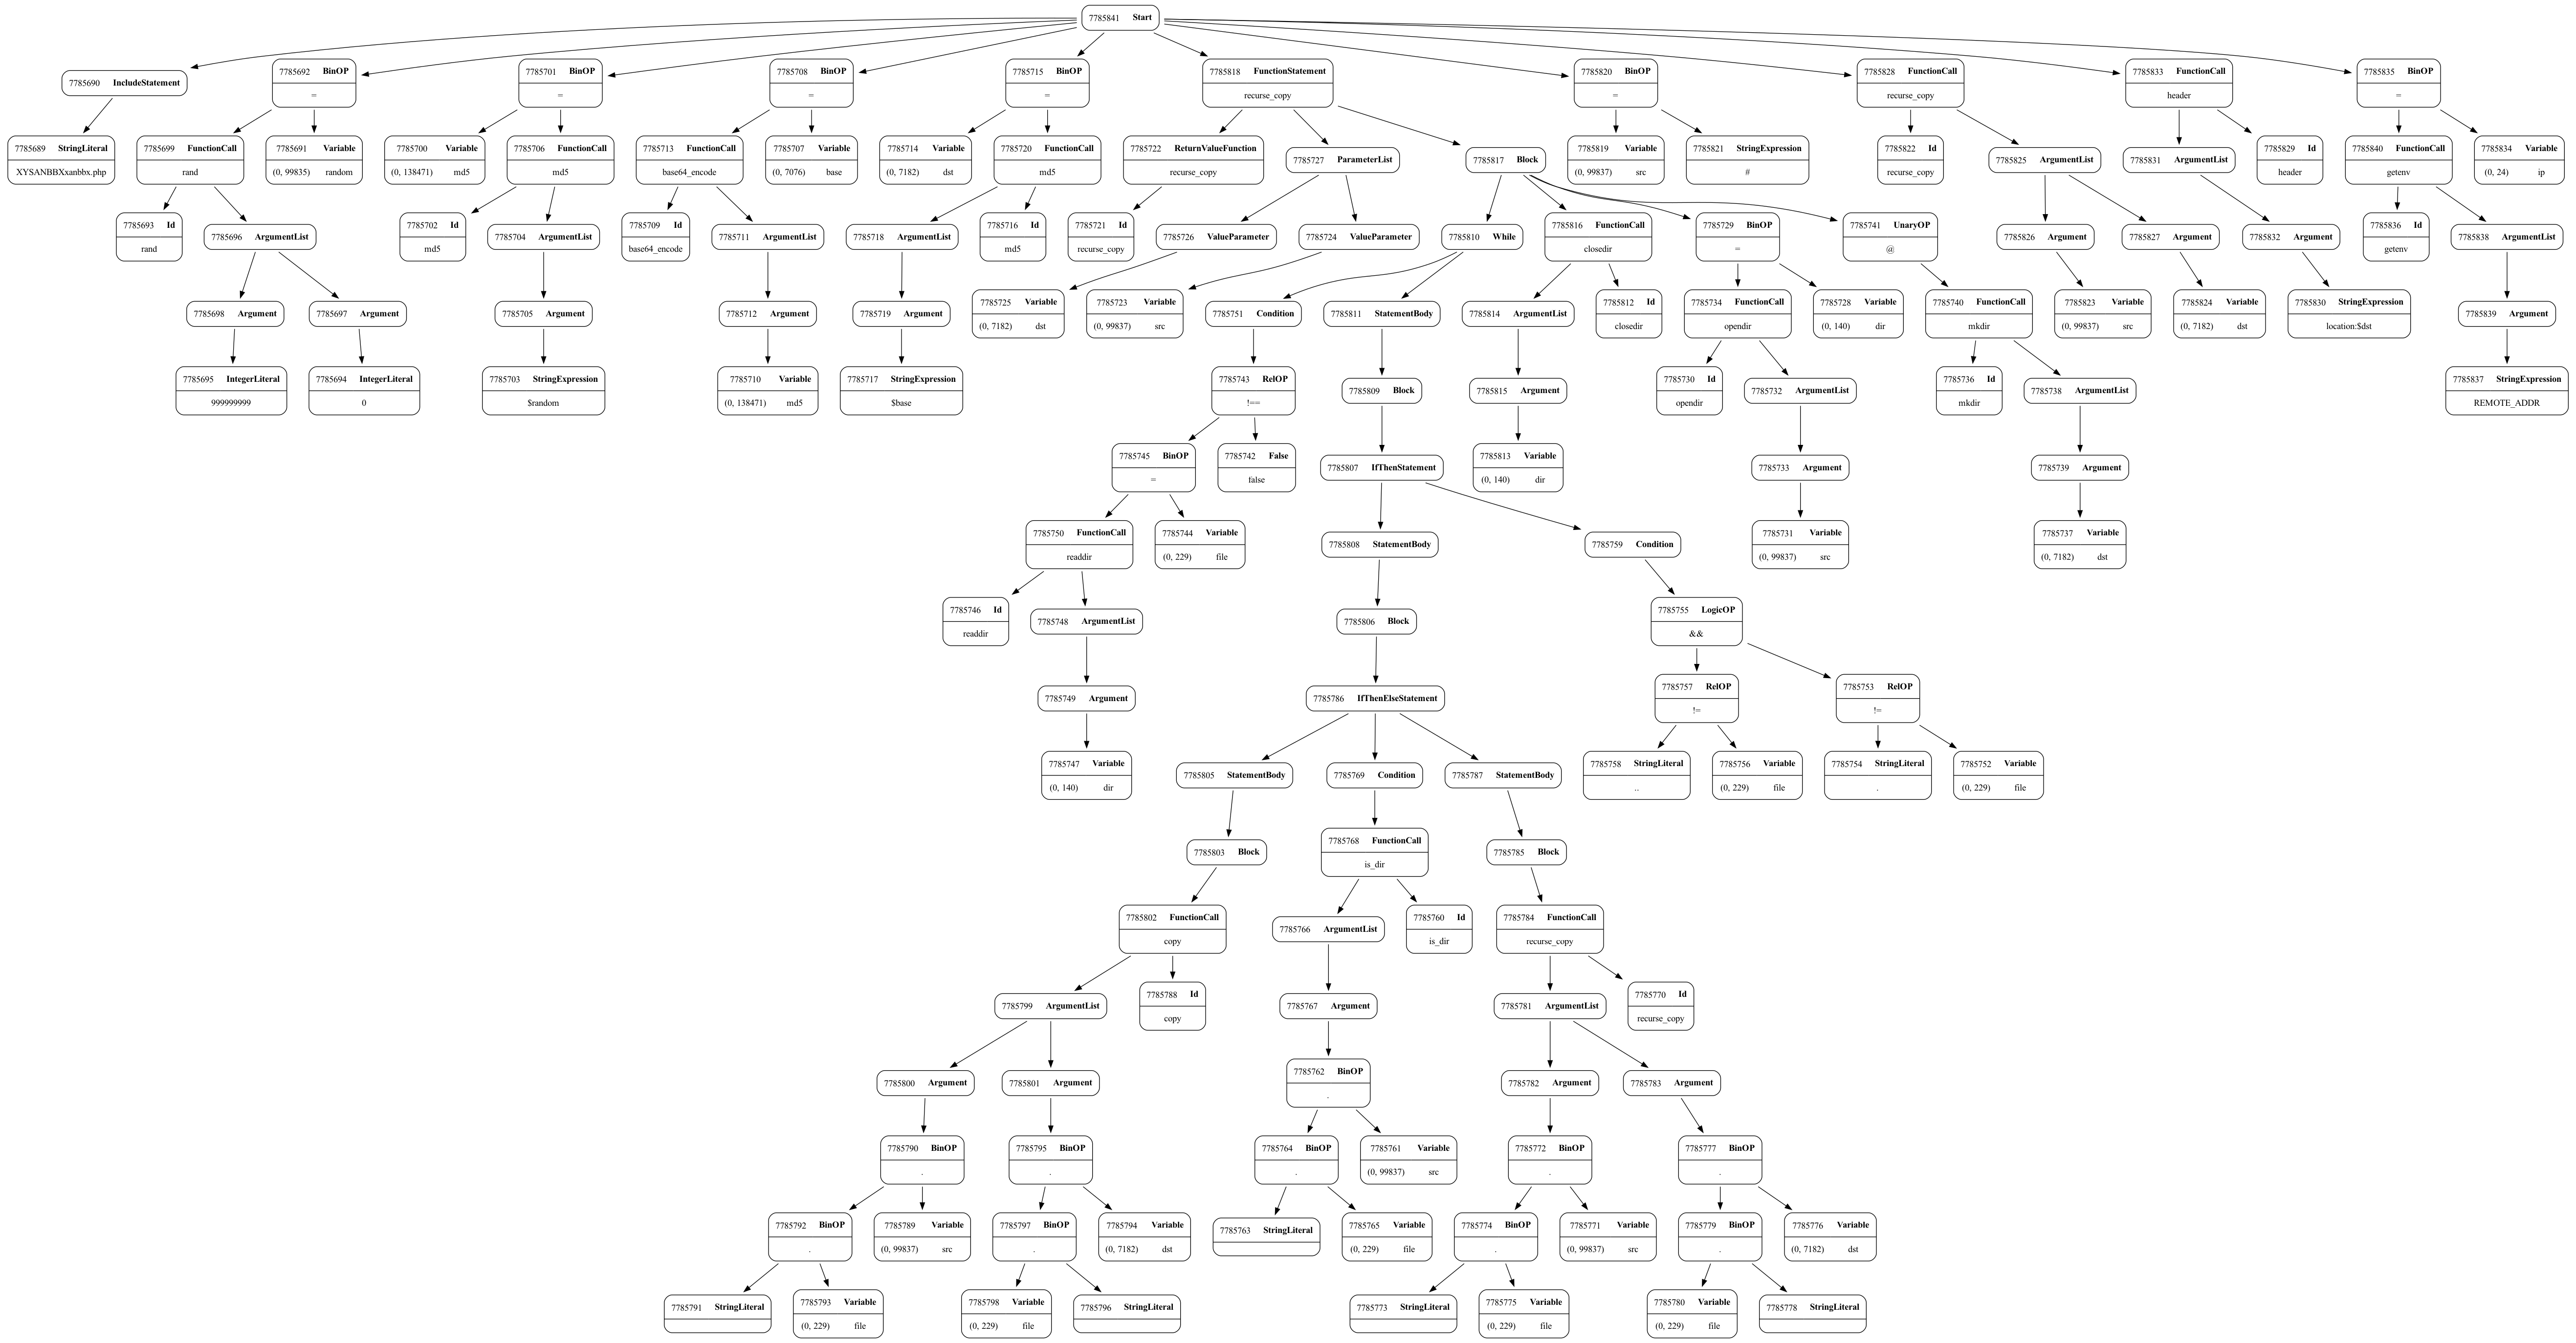

In [19]:
sample_ast = list(all_kits_asts.values())[0][0]

show_graph(sample_ast)

In [22]:
sample_ast.vectorize()

array([ 0,  0,  0,  0, 14, 18,  0,  0,  0,  0, 18,  5,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, 14,  1,  0,  0,  0,  0,
       15,  0,  0,  1,  1,  0,  1,  0,  0,  0,  0,  0,  2,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,
        1,  0,  1,  4,  0,  0,  5,  8,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  2, 29,  0,  0,  1])